# Run large FaIR ensemble

Theme Song: Hammers<br>
Artist: Nils Frahm<br>
Album: Spaces<br>
Released: 2013

Runs the parameter set generated in #140

In [1]:
import errno
import fair
import json
import sys
import os
import random
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as pl
import pandas as pd
import pickle
from multiprocessing import Pool

from netCDF4 import Dataset
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
from fair.constants import molwt
from fair.ancil import natural, cmip6_volcanic, cmip6_solar
from ar6.forcing.aerosol import ghan
from ar6.constants import NINETY_TO_ONESIGMA

In [2]:
fair.__version__

'1.6.2'

## Ensemble generation

We want to ensure reproducible results that don't change when this script is re-run. Grab list of pre-generated random seeds.

In [3]:
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [4]:
SAMPLES = 1000000
F2XCO2_MEAN = 4.00
F2XCO2_NINETY = 0.48

# I now think we have everything we need to run FaIR with

Before tackling the AR6-WG3 format, let's see how they look before we let this loose on the world.

In [5]:
#ssp_df = pd.read_csv(os.path.join(os.path.dirname(fair.__file__), 'SSPs/data/rcmip-emissions-annual-means-4-0-0-ssp-only.csv'))
ssp_df = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')

In [6]:
years = np.arange(1750,2101)
startyear = 1750
first_scenyear = 2015
last_scenyear = 2100
first_row = int(first_scenyear-startyear)
last_row = int(last_scenyear-startyear)

species = [  # in fair 1.6, order is important
    '|CO2|MAGICC Fossil and Industrial',
    '|CO2|MAGICC AFOLU',
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|CF4',
    '|C2F6',
    '|C6F14',
    '|HFC23',
    '|HFC32',
    '|HFC4310mee',
    '|HFC125',
    '|HFC134a',
    '|HFC143a',
    '|HFC227ea',
    '|HFC245fa',
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

# Assume that units coming out of aneris don't change. One day I'll do unit parsing
unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

data_out = {}

scens = ['ssp245']
for scen in scens:
    data_out[scen] = np.ones((351, 40)) * np.nan
    data_out[scen][:,0] = years

    years_future = [2015] + list(range(2020,2101,10))
    for i, specie in enumerate(species):
        data_out[scen][:first_row,i+1] = ssp_df.loc[(ssp_df['Model']=='MESSAGE-GLOBIOM')&(ssp_df['Region']=='World')&(ssp_df['Scenario']==scen)&(ssp_df['Variable'].str.endswith(specie)),str(startyear):'2014']*unit_convert[i+1]
        f = interp1d(years_future, ssp_df.loc[(ssp_df['Model']=='MESSAGE-GLOBIOM')&(ssp_df['Region']=='World')&(ssp_df['Scenario']==scen)&(ssp_df['Variable'].str.endswith(specie)),'2015':'2100'].dropna(axis=1))
        data_out[scen][first_row:(last_row+1), i+1] = f(np.arange(first_scenyear, last_scenyear+1))*unit_convert[i+1]

In [7]:
data_out['ssp245'].shape

(351, 40)

In [8]:
data_out['ssp245'][250,:]

array([2.00000000e+03, 6.88899310e+00, 1.20061057e+00, 3.10186810e+02,
       6.11111906e+00, 5.55743021e+01, 8.86564730e+02, 1.95324158e+02,
       4.12492764e+01, 7.45734723e+00, 2.79819784e+01, 5.45095965e+01,
       9.92314570e+00, 2.81539430e+00, 8.27090430e-01, 9.29783890e+00,
       1.41149200e+00, 5.74232780e-01, 1.06406670e+01, 9.96574240e+01,
       8.59875630e+00, 8.63199880e-01, 3.40069260e-02, 5.27353320e+00,
       7.63300760e+01, 1.22766050e+02, 9.40438840e+00, 3.98671420e+00,
       2.34765180e+00, 7.26514080e+01, 1.94712270e+01, 2.63606270e+02,
       5.63416860e+01, 2.57301520e+01, 9.48013480e+00, 0.00000000e+00,
       1.96944120e+00, 7.71519220e-01, 1.65258760e+02, 5.07426960e+03])

In [9]:
# add in natural emissions and natural forcing
ch4_n2o_df = pd.read_csv('../data_output/fair_wg3_natural_ch4_n2o.csv')
ch4_n2o = ch4_n2o_df.values[:351,1:]

df = pd.read_csv('../data_output/solar_erf.csv', index_col='year')
solar_forcing = df.solar_erf.loc[1750:2100].values

df = pd.read_csv('../data_output/volcanic_erf.csv', index_col='year')
volcanic_forcing = np.zeros((351))
volcanic_forcing[:269] = df.volcanic_erf.loc[1750:2018].values
# ramp down last 10 years to zero according to https://www.geosci-model-dev.net/9/3461/2016/gmd-9-3461-2016.html
volcanic_forcing[268:279] = volcanic_forcing[268] * np.linspace(1,0,11)
volcanic_forcing[279:] = 0.

## Build a list of dicts to run FaIR with

- apply adjustments to the WMGHGs by overwriting the scale factors
- CO2 already includes adjustments through F2x
- 190 GtC 1750-2019

In [10]:
aCO2land = -0.2 / 190

In [11]:
E_ref_BC = 6.095

In [12]:
# ozone
ozone_feedback = np.load('../data_input_large/fair-samples/ozone_feedback_unconstrained.npy')
beta_ch4 = np.load('../data_input_large/fair-samples/beta_ch4_unconstrained.npy')
beta_n2o = np.load('../data_input_large/fair-samples/beta_n2o_unconstrained.npy')
beta_ods = np.load('../data_input_large/fair-samples/beta_ods_unconstrained.npy')
beta_co = np.load('../data_input_large/fair-samples/beta_co_unconstrained.npy')
beta_voc = np.load('../data_input_large/fair-samples/beta_voc_unconstrained.npy')
beta_nox = np.load('../data_input_large/fair-samples/beta_nox_unconstrained.npy')

# carbon cycle
r0 = np.load('../data_input_large/fair-samples/r0_unconstrained.npy')
rC = np.load('../data_input_large/fair-samples/rC_unconstrained.npy')
rT = np.load('../data_input_large/fair-samples/rT_unconstrained.npy')
pre_ind_co2 = np.load('../data_input_large/fair-samples/pre_ind_co2_unconstrained.npy')

# aerosol
beta_so2 = np.load('../data_input_large/fair-samples/beta_so2_unconstrained.npy')
beta_bc = np.load('../data_input_large/fair-samples/beta_bc_unconstrained.npy')
beta_oc = np.load('../data_input_large/fair-samples/beta_oc_unconstrained.npy')
beta_nh3 = np.load('../data_input_large/fair-samples/beta_nh3_unconstrained.npy')
beta = np.load('../data_input_large/fair-samples/beta_unconstrained.npy')
aci_coeffs = np.load('../data_input_large/fair-samples/aci_coeffs.npy')

# forcing
scale_normals = np.load('../data_input_large/fair-samples/scale_normals.npy')
trend_solar = np.load('../data_input_large/fair-samples/scale_trend_solar.npy')

# climate response
geoff_sample_df = pd.read_csv('../data_output_large/geoff_sample.csv')
f2x = np.load('../data_input_large/fair-samples/f2x_unconstrained.npy')

scen='ssp245'
E_pi=np.zeros(40)
# unit convert not necessary as this has been done going in
E_pi[5]=1.22002422
E_pi[6]=348.527359
E_pi[7]=60.0218262
E_pi[8]=3.87593407
E_pi[9]=2.09777075
E_pi[10]=15.4476682
E_pi[11]=6.92769009

aCO2land = -0.2 / 190
E_ref_BC = 6.095

arglist = []
for i in tqdm(range(SAMPLES)):
    # should we use RCMIP or AR6 values??
    # do not move this out of the loop
    C_pi=np.zeros(31)
    C_pi[0] = pre_ind_co2[i]
    C_pi[1]=731.406
    C_pi[2]=273.8651
    C_pi[3]=34.05
    C_pi[4] = 32.28077001      # where did this come from? 
    C_pi[25]=0.00434894
    C_pi[29]=8.75191031
    C_pi[30]=755.7838942
    scale = np.ones(45)
    scale[1] = scale_normals[i,1] * 0.86 # methane adjustment
    scale[2] = scale_normals[i,2] * 1.07
    scale[3:31] = scale_normals[i,3]
    scale[15] = scale_normals[i,3] * 1.13 # cfc11 adjustment
    scale[16] = scale_normals[i,3] * 1.12 # cfc12 adjustment
    #scale[31] = scale_normals[i,4]
    scale[33:35] = scale_normals[i,5:7]
    scale[41:44] = scale_normals[i,7:10]
    F_solar = np.zeros(351)
    F_solar[:270] = np.linspace(0,trend_solar[i],270) + solar_forcing[:270]*scale_normals[i,10]
    F_solar[270:351] = trend_solar[i] + solar_forcing[270:351]*scale_normals[i,10]
    arglist.append(
        {
            'ghg_forcing': 'Meinshausen',
            'emissions': data_out[scen],
            'natural': ch4_n2o,
            'F_volcanic': volcanic_forcing,
            'F_solar': solar_forcing,
            'efficacy': np.ones(45),
            'diagnostics': 'AR6',
            'gir_carbon_cycle': True,
            'aerosol_forcing': 'aerocom+ghan2',
            'fixPre1850RCP': False,
            'E_pi': E_pi,
            'temperature_function': 'Geoffroy',
            'b_tro3': np.array([beta_ch4[i], beta_n2o[i], beta_ods[i], beta_co[i], beta_voc[i], beta_nox[i]]),
            'ozone_feedback': ozone_feedback[i],
            'tropO3_forcing': 'thornhill-skeie',
            'aCO2land': aCO2land,
            'stwv_from_ch4': 0.079047,
            'F_ref_BC': 0.08,
            'E_ref_BC': E_ref_BC,
            'C_pi': C_pi,
            'F2x': f2x[i],
            'r0': r0[i],
            'rc': rC[i],
            'rt': rT[i],
            'lambda_global': -geoff_sample_df.loc[i, 'lamg'],  # this and the below only used in two-layer model
            'ocean_heat_capacity': np.array([geoff_sample_df.loc[i, 'cmix'], geoff_sample_df.loc[i, 'cdeep']]),
            'ocean_heat_exchange': geoff_sample_df.loc[i, 'gamma_2l'],
            'deep_ocean_efficacy': geoff_sample_df.loc[i, 'eff'],
            'b_aero': np.array([beta_so2[i], 0.0, 0.0, 0.0, beta_bc[i], beta_oc[i], beta_nh3[i]]),
            'ghan_params': np.array([beta[i], aci_coeffs[i,0], aci_coeffs[i,1]]),
            'scale': scale,
        }
    )

  0%|          | 0/1000000 [00:00<?, ?it/s]

## Run in parallel on 16 processors

Depending on your machine you might want to change this number.

** CHECK OUTPUT IS SAVED! **

In [13]:
def run_fair(args):
    thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
    return (
        thisC[:,0], 
        thisF[:,31], 
        np.sum(thisF[:,35:40], axis=1),
        thisF[:,40],
        np.sum(thisF[:,:43], axis=1),
        np.sum(thisF, axis=1),
        thisT,
        thisOHU,
        thisAF
    )

if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, arglist), total=SAMPLES))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [14]:
len(result[0])

9

In [15]:
result_t = np.array(result).transpose(1,2,0)

In [16]:
C_CO2, F_O3, F_dir, F_ind, F_ant, F_tot, T, OHU, AF = result_t

np.save('../data_output_large/fair-samples/F_O3_unconstrained.npy', F_O3)
np.save('../data_output_large/fair-samples/F_ERFari_unconstrained.npy', F_dir)
np.save('../data_output_large/fair-samples/F_ERFaci_unconstrained.npy', F_ind)
np.save('../data_output_large/fair-samples/F_anthro_unconstrained.npy', F_ant)
np.save('../data_output_large/fair-samples/F_total_unconstrained.npy', F_tot)
np.save('../data_output_large/fair-samples/C_CO2_unconstrained.npy', C_CO2)
np.save('../data_output_large/fair-samples/T_unconstrained.npy', T)
np.save('../data_output_large/fair-samples/OHU_unconstrained.npy', OHU)
np.save('../data_output_large/fair-samples/AF_unconstrained.npy', AF)

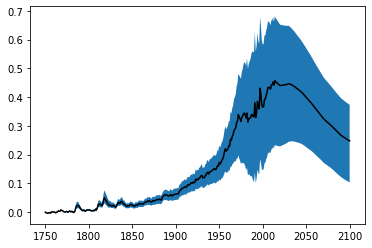

In [17]:
pl.fill_between(np.arange(1750,2101), np.percentile(F_O3, 5, axis=1), np.percentile(F_O3, 95, axis=1))
pl.plot(np.arange(1750,2101), np.percentile(F_O3, 50, axis=1), color='k')

In [18]:
np.percentile(F_O3, 50, axis=1)[350]

0.24783004275642553

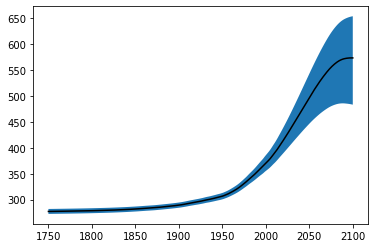

In [19]:
pl.fill_between(np.arange(1750,2101), np.percentile(C_CO2, 5, axis=1), np.percentile(C_CO2, 95, axis=1))
pl.plot(np.arange(1750,2101), np.percentile(C_CO2, 50, axis=1), color='k')

(array([1.90000e+01, 8.26000e+02, 1.57470e+04, 1.13282e+05, 3.21406e+05,
        3.60226e+05, 1.59118e+05, 2.75140e+04, 1.81800e+03, 4.40000e+01]),
 array([262.24068083, 265.15863001, 268.07657918, 270.99452835,
        273.91247753, 276.8304267 , 279.74837588, 282.66632505,
        285.58427423, 288.5022234 , 291.42017258]),
 <a list of 10 Patch objects>)

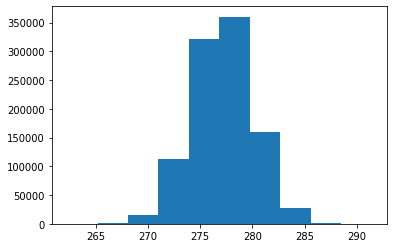

In [20]:
pl.hist(C_CO2[0,:])

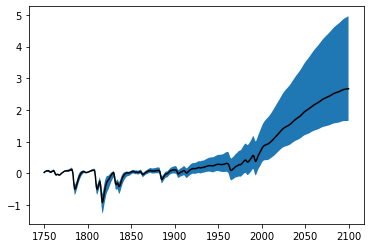

In [21]:
pl.fill_between(np.arange(1750,2101), np.percentile(T, 5, axis=1), np.percentile(T, 95, axis=1))
pl.plot(np.arange(1750,2101), np.percentile(T, 50, axis=1), color='k')